In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install biopython
from Bio import SeqIO
from Bio.Seq import Seq
import os
from scipy.stats import shapiro, normaltest, mannwhitneyu, pearsonr
from Bio.Data import CodonTable
import itertools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.3 MB/s eta 0:00:00


In [ ]:
prion_non_prion_df = pd.read_csv('/content/drive/MyDrive/Lin Chen Rotation/prion_vs_non_prion_df.tsv', sep='\t')

prion_seqs = pd.read_csv('/content/drive/MyDrive/Lin Chen Rotation/full_length_prion_seqs.tsv', sep='\t')
prion_seqs.drop([2, 3, 5, 13, 15], inplace=True) # dropping SNT1, RBS1, PSP1, AZF1, and VTS1 (indices 2, 3, 5, 13, and 15)
prion_seqs.reset_index(inplace=True, drop=True)

PrD_prions_df = pd.read_csv('/content/drive/MyDrive/Lin Chen Rotation/PrD_prions_df.tsv', sep='\t')
non_PrD_prions_df = pd.read_csv('/content/drive/MyDrive/Lin Chen Rotation/non_PrD_prions_df.tsv', sep='\t')

prd_sequences = pd.read_csv('/content/drive/MyDrive/Lin Chen Rotation/prion_forming_domains_sequences.tsv', sep='\t')
non_prd_sequences = pd.read_csv('/content/drive/MyDrive/Lin Chen Rotation/non_prion_forming_domains_sequences.tsv', sep='\t')

# Separating Prion sequences into PrD and non-PrD

In [ ]:
def add_prd_non_prd(df, split_positions):

    df = df.copy()

    prd_prot_col, non_prd_prot_col = [], []
    prd_dna_col, non_prd_dna_col = [], []

    for _, row in df.iterrows():
        gene_name = row["Gene Name"]
        protein_seq = row["Protein Sequence"]
        gene_seq = row['Sequence']

        start_aa, end_aa = map(int, split_positions[gene_name].split('-'))
        start_nt = (start_aa - 1) * 3 + 1
        end_nt = end_aa * 3

        if end_aa == len(protein_seq):
            end_nt += 3  # Include the stop codon

        prd_prot_seq = protein_seq[start_aa-1:end_aa]
        non_prd_prot_seq = protein_seq[:start_aa-1] + protein_seq[end_aa:]

        prd_dna_seq = gene_seq[start_nt-1:end_nt]
        non_prd_dna_seq = gene_seq[:start_nt-1] + gene_seq[end_nt:]

        prd_prot_col.append(prd_prot_seq)
        non_prd_prot_col.append(non_prd_prot_seq)

        prd_dna_col.append(prd_dna_seq)
        non_prd_dna_col.append(non_prd_dna_seq)

    df["PrD Protein Sequence"] = prd_prot_col
    df["non-PrD Protein Sequence"] = non_prd_prot_col

    df["PrD DNA Sequence"] = prd_dna_col
    df["non-PrD DNA Sequence"] = non_prd_dna_col

    return df

split_positions = split_positions = {
    "SUP35": "1-135",
    "CYC8": "443-682",
    "RNQ1": "153-405",
    "URE2": '1-89',
    "NEW1": '1-153',
    'SWI1': '1-323',
    'MOD5': '194-215',
    'MOT3': '1-295',
    'GLN3': '166-242',
    'SFP1': '230-458',
    'SKY1': '353-491',
    'PUB1': '290-386',
    'PIN2': '221-282',
    # 'AZF1': '1-300',
    # 'VTS1': '1-420',
    # 'SNT1': '1-1226',
    # 'RBS1': '260-400',
    # 'PSP1': '50-400'
}
separated_prion_domains = add_prd_non_prd(prion_seqs, split_positions)
prion_forming_domains = separated_prion_domains.drop(columns=['Sequence', 'Protein Sequence', 'non-PrD Protein Sequence', 'non-PrD DNA Sequence'])
non_prion_forming_domains = separated_prion_domains.drop(columns=['Sequence', 'Protein Sequence', 'PrD Protein Sequence', 'PrD DNA Sequence'])
prion_forming_domains.rename(columns={'PrD Protein Sequence': 'Protein Sequence', 'PrD DNA Sequence': 'Sequence'}, inplace=True)
non_prion_forming_domains.rename(columns={'non-PrD Protein Sequence': 'Protein Sequence', 'non-PrD DNA Sequence': 'Sequence'}, inplace=True)

# Parsing the fasta file and converting it into a dataframe that is easy to work with.

In [ ]:
fasta_path = '/content/drive/MyDrive/Lin Chen Rotation/orf_coding_all_R64-4-1_20230830.fasta'

data = []

fasta_file = open(fasta_path, 'r')
for record in SeqIO.parse(fasta_file, 'fasta'):
    record_id = record.id
    prion_or_non_prion_info = record.description
    gene_info = record.description.split(',')
    sequence = str(record.seq)
    gene_name = gene_info[0].split(' ')[1]
    orf_types = ['Dubious ORF', 'Uncharacterized ORF', 'Verified ORF']
    orf_type = None
    for item in gene_info:
      match = re.search(rf'\b({"|".join(orf_types)})\b', item, re.IGNORECASE)
      if match:
        orf_type = match.group(0)
        break

    data.append([record_id, gene_name, orf_type, prion_or_non_prion_info, sequence])

df = pd.DataFrame(data, columns=['ID', 'Gene Name', 'ORF', 'Prion Formation', 'Sequence'])
df = df[df['ORF'] == 'Verified ORF'] # Filter anything that's not a verified ORF
# print(df['ORF'].value_counts()) # we have 5254 verified ORFs, 684 Dubious ORFs, and 669 Uncharacterized ORFs
df['Prion Formation'] = df['Prion Formation'].apply(lambda x: 1 if "+]" in x else 0)
prion_genes_not_caught_by_plus_symbol = ['SUP35', 'GLN3', 'YLR278C', 'SKY1', 'URE2', 'PUB1', 'MOD5']
false_prion_genes_caught_by_plus_symbol = ['PIN3', 'PMA1', 'HSP104']
df.loc[df['Gene Name'].isin(prion_genes_not_caught_by_plus_symbol), 'Prion Formation'] = 1
df.loc[df['Gene Name'].isin(false_prion_genes_caught_by_plus_symbol), 'Prion Formation'] = 0

def validate_sequence(seq):
    divisible_by_3 = len(seq) % 3 == 0

    starts_with_atg = seq.startswith('ATG')

    ends_with_valid_codon = seq.endswith(('TAA', 'TAG', 'TGA'))

    return divisible_by_3 and starts_with_atg and ends_with_valid_codon

all_valid = df['Sequence'].apply(validate_sequence).all()

if all_valid:
    print("All sequences are valid!")
else:
    print("Some sequences are invalid.")
# We ensure that all sequences are valid!

All sequences are valid!


In [ ]:
df.head()

,ID,Gene Name,ORF,Prion Formation,Sequence
2,YAL068C,PAU8,Verified ORF,0,ATGGTCAAATTAACTTCAATCGCCGCTGGTGTCGCTGCCATCGCTG...
4,YAL067C,SEO1,Verified ORF,0,ATGTATTCAATTGTTAAAGAGATTATTGTAGATCCTTACAAAAGAC...
9,YAL064W,YAL064W,Verified ORF,0,ATGAATCCTTTTGCATCGCTAGAAGGACAAGATAATATTTCTTCTG...
11,YAL063C,FLO9,Verified ORF,0,ATGTCTCTGGCACATTATTGTTTACTACTAGCCATCGTCACATTGC...
12,YAL062W,GDH3,Verified ORF,0,ATGACAAGCGAACCAGAGTTTCAGCAGGCTTACGATGAGATCGTTT...


In [ ]:
print(len(df) - sum(df['Prion Formation'])) # we have 5236 non-prion-forming genes
print(sum(df['Prion Formation'])) # we have 18 prion-forming genes and

5236
18


# Calculating DNA Composition (each nucleotide percentage)

In [ ]:
nucleotides = ['A', 'T', 'G', 'C']

def count_nucleotides(dna_sequence):
    return {nuc: (dna_sequence.count(nuc) / len(dna_sequence)) * 100 for nuc in nucleotides}

def calculate_nucleotide_composition(df):
 nucleotide_results = []

 for _, row in df.iterrows():
    counts = count_nucleotides(row['Sequence'])
    counts['ID'] = row['ID']  # the ID is needed for later merging
    nucleotide_results.append(counts)

 nucleotide_counts_df = pd.DataFrame(nucleotide_results)

 nucleotide_counts_df.rename(columns={'A': 'Ad', 'T': 'Th', 'G': 'Gu', 'C': 'Cy'}, inplace=True)

 return nucleotide_counts_df

# for entire dataset
nucleotide_counts_df = calculate_nucleotide_composition(df)
df = pd.merge(df, nucleotide_counts_df, on='ID')

# for prions {PrDs}
nuc_pfds = calculate_nucleotide_composition(prion_forming_domains)
prion_forming_domains = pd.merge(prion_forming_domains, nuc_pfds, on='ID')

# for prions {non-PrDs}
nuc_non_pfds = calculate_nucleotide_composition(non_prion_forming_domains)
non_prion_forming_domains = pd.merge(non_prion_forming_domains, nuc_non_pfds, on='ID')

# Translating the DNA sequences of the genes

In [ ]:
def translate_dna(seq):
    return str(Seq(seq).translate(to_stop=True))
df['Protein Sequence'] = df['Sequence'].apply(translate_dna)

# Calculating the protein composition for every gene

In [ ]:
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

def count_amino_acids(protein_sequence):
    # Calculate percentage for each amino acid
    return {aa: (protein_sequence.count(aa) / len(protein_sequence)) * 100 for aa in amino_acids}

def calculate_amino_acid_composition(df):
 amino_acid_results = []

 for _, row in df.iterrows():
    counts = count_amino_acids(row['Protein Sequence'])
    counts['ID'] = row['ID']  # the ID is needed for later merging
    amino_acid_results.append(counts)

 amino_acid_counts_df = pd.DataFrame(amino_acid_results)
 return amino_acid_counts_df

# for entire dataset
amino_acid_counts_df = calculate_amino_acid_composition(df)
amino_acid_df = pd.merge(df, amino_acid_counts_df, on='ID')
amino_acid_df['Sequence'] = amino_acid_df['Sequence'].astype(str)

# for prions {PrDs}
amino_acid_pfds = calculate_amino_acid_composition(prion_forming_domains)
prion_forming_domains = pd.merge(prion_forming_domains, amino_acid_pfds, on='ID')
prion_forming_domains['Sequence'] = prion_forming_domains['Sequence'].astype(str)

# for prions {non_PrDs}
amino_acid_non_pfds = calculate_amino_acid_composition(non_prion_forming_domains)
non_prion_forming_domains = pd.merge(non_prion_forming_domains, amino_acid_non_pfds, on='ID')
non_prion_forming_domains['Sequence'] = non_prion_forming_domains['Sequence'].astype(str)

# A random sampling function. This should be used inside some big loop whenever comparig group_1 to group_0 (which shall be some "averaged" group_0 based on this function).

In [ ]:
def random_sample(df, N):

    sampled_df = df.sample(n=N, random_state=None)

    return sampled_df

In [ ]:
random_df = random_sample(amino_acid_df[amino_acid_df['Prion Formation'] == 0], 15)
random_df

,ID,Gene Name,ORF,Prion Formation,Sequence,Ad,Th,Gu,Cy,Protein Sequence,...,L,K,M,F,P,S,T,W,Y,V
2707,YJR010C-A,SPC1,Verified ORF,0,ATGTCTGAGATATTACAAGATGTACAAAGGAAACTGGTTTTTCCAA...,32.280702,29.824561,21.052632,16.842105,MSEILQDVQRKLVFPIDFPSQRKTEKFQQLSLMIGALVACILGFAQ...,...,12.765957,7.446809,2.127660,4.255319,5.319149,5.319149,3.191489,2.127660,4.255319,7.446809
1436,YER104W,RTT105,Verified ORF,0,ATGTACAGCAATCATAATTTAAATTCGGATGACTGTTGCTTCGATT...,35.087719,24.401914,21.052632,19.457735,MYSNHNLNSDDCCFDWNEEKAAELQRTGVSFDRSLTPQSLRTSTRR...,...,7.692308,4.807692,4.807692,2.884615,3.365385,11.057692,4.807692,0.961538,2.403846,2.403846
1710,YGL153W,PEX14,Verified ORF,0,ATGAGTGACGTGGTCAGTAAAGATCGTAAGGCATTGTTCGACTCAG...,37.134503,22.027290,23.294347,17.543860,MSDVVSKDRKALFDSAVSFLKDESIKDAPLLKKIEFLKSKGLTEKE...,...,6.744868,10.557185,3.519062,2.639296,4.105572,8.211144,4.398827,1.173021,1.759531,4.985337
510,YCR018C,SRD1,Verified ORF,0,ATGCGATATAATAATTATGACAACTCTGGAAGTTCCTTCTTAACTA...,40.540541,22.072072,21.021021,16.366366,MRYNNYDNSGSSFLTRVVKKSDMEKTLLLNREIDDWKSNDKKKAYK...,...,5.429864,12.669683,0.904977,1.357466,2.714932,10.859729,6.787330,1.357466,3.167421,3.619910
449,YCL061C,MRC1,Verified ORF,0,ATGGATGATGCCTTGCATGCTTTGTCCTCGTTGACTGCAAAGAAGA...,39.987846,22.303251,20.176238,17.532665,MDDALHALSSLTAKKRTTTYKKVAVPILDENDNTNGNGPNDIDNPP...,...,7.481752,10.857664,1.368613,2.554745,3.649635,9.032847,5.930657,0.091241,1.824818,3.923358
1441,YER111C,SWI4,Verified ORF,0,ATGCCATTTGATGTTTTGATATCAAACCAAAAAGATAATACCAATC...,39.945155,25.502742,15.478367,19.073736,MPFDVLISNQKDNTNHQNITPISKSVLLAPHSNHPVIEIATYSETD...,...,7.319305,8.417200,2.378774,3.019213,4.940531,11.436414,6.312900,0.365965,2.561757,3.476670
342,YBR191W,RPL21A,Verified ORF,0,ATGGGTAAATCACACGGTTACAGATCTCGTACTCGTTACATGTTCC...,31.055901,27.122153,20.703934,21.118012,MGKSHGYRSRTRYMFQRDFRKHGAVHLSTYLKVYKVGDIVDIKANG...,...,5.000000,10.625000,2.500000,3.125000,3.750000,5.625000,4.375000,0.000000,5.000000,10.625000
1839,YGL001C,ERG26,Verified ORF,0,ATGTCAAAGATAGATTCAGTTTTAATTATCGGTGGTTCTGGTTTTC...,29.714286,30.666667,22.285714,17.333333,MSKIDSVLIIGGSGFLGLHLIQQFFDINPKPDIHIFDVRDLPEKLS...,...,7.449857,7.449857,2.292264,4.584527,5.444126,4.297994,5.157593,1.719198,2.865330,8.309456
926,YDR156W,RPA14,Verified ORF,0,ATGATGAAAGGTTCTAGAAGAACAGGTAATAACACTGCTACCACGC...,28.743961,20.289855,23.188406,27.777778,MMKGSRRTGNNTATTLNTPVVIHATQLPQHVSTDEVLQFLESFIDE...,...,5.839416,5.839416,2.189781,3.649635,3.649635,10.218978,13.138686,0.000000,0.000000,5.109489
2584,YJL136C,RPS21B,Verified ORF,0,ATGGAAAACGATAAGGGTCAATTAGTTGAATTATATGTTCCAAGAA...,28.787879,28.030303,22.348485,20.833333,MENDKGQLVELYVPRKCSATNRIIKADDHASVQINVAKVDEEGRAI...,...,8.045977,5.747126,1.149425,0.000000,2.298851,9.195402,2.298851,1.149425,5.747126,8.045977


# Adding amino acids with their correspodning codons so that we understand codon bias

In [ ]:
# Standard codon table
codon_table = CodonTable.unambiguous_dna_by_id[1]

# Mapping of codons to amino acids (excluding stop codons)
codon_to_aa = codon_table.forward_table

all_codons = {f"{aa}_{codon}" for codon, aa in codon_to_aa.items()}

def codon_count_per_aa(seq):
    codons = [seq[i:i+3] for i in range(0, len(seq), 3)]
    if seq.endswith(('TAA', 'TAG', 'TGA')):
        num_codons = len(codons) - 1
    else:
        num_codons = len(codons)

    codon_counts = {col: 0 for col in all_codons}

    for codon in codons:
        if codon in codon_to_aa:
            aa = codon_to_aa[codon]
            column_name = f"{aa}_{codon}"
            codon_counts[column_name] += 1

    # Normalize by the total number of codons
    return {key: ((value / num_codons) * 100) if num_codons > 0 else 0 for key, value in codon_counts.items()}

def add_codon_bias(df):
    codon_results = []

    for _, row in df.iterrows():
        counts = codon_count_per_aa(row['Sequence'])
        counts['ID'] = row['ID']  # Keep ID for merging
        codon_results.append(counts)

    codon_df = pd.DataFrame(codon_results).fillna(0)
    return codon_df

codon_df = add_codon_bias(amino_acid_df)
complete_df = pd.merge(amino_acid_df, codon_df, on='ID')

codon_pfds = add_codon_bias(prion_forming_domains)
prion_forming_domains = pd.merge(prion_forming_domains, codon_pfds, on='ID')

codon_non_pfds = add_codon_bias(non_prion_forming_domains)
non_prion_forming_domains = pd.merge(non_prion_forming_domains, codon_non_pfds, on='ID')

# GC Content to be compared between the two gene groups.

In [ ]:
complete_df['GC_Content'] = complete_df['Gu'] + complete_df['Cy']
prion_forming_domains['GC_Content'] = prion_forming_domains['Gu'] + prion_forming_domains['Cy']
non_prion_forming_domains['GC_Content'] = non_prion_forming_domains['Gu'] + non_prion_forming_domains['Cy']

# C and G in 1st or 2nd position codon frequency comparison.

In [ ]:
def contains_in_first_or_second_pos(col_name, letter):
    parts = col_name.split('_') # because this is how I named my columns
    suffix = parts[1]
    return letter in suffix[:2] # Check the first and second characters of the suffix

def contains_in_third_pos(col_name, letter):
    parts = col_name.split('_') # because this is how I named my columns
    suffix = parts[1]
    return letter in suffix[-1] # Check the last letter of the suffix (third nucleotide of any codon)

# complete_df.iloc[:, 30:-1] --> This was used to slice only the columns with the codons
# columns_with_c_at_first_or_second_pos = [col for col in complete_df.iloc[:, 30:-1].columns if contains_in_first_or_second_pos(col, 'C')]
columns_with_c_at_third_pos = [col for col in complete_df.iloc[:, 30:91].columns if contains_in_third_pos(col, 'C')]

# complete_df['Codons_with_c_at_first_or_second_pos'] = complete_df[columns_with_c_at_first_or_second_pos].sum(axis=1)
complete_df['Codons_with_c_at_third_pos'] = complete_df[columns_with_c_at_third_pos].sum(axis=1)

# prion_forming_domains['Codons_with_c_at_first_or_second_pos'] = prion_forming_domains[columns_with_c_at_first_or_second_pos].sum(axis=1)
PrD_prions_df['Codons_with_c_at_third_pos'] = PrD_prions_df[columns_with_c_at_third_pos].sum(axis=1)

# non_prion_forming_domains['Codons_with_c_at_first_or_second_pos'] = non_prion_forming_domains[columns_with_c_at_first_or_second_pos].sum(axis=1)
non_PrD_prions_df['Codons_with_c_at_third_pos'] = non_PrD_prions_df[columns_with_c_at_third_pos].sum(axis=1)

In [ ]:
columns_with_g_at_first_or_second_pos = [col for col in complete_df.iloc[:, 30:-3].columns if contains_in_first_or_second_pos(col, 'G')]
columns_with_g_at_third_pos = [col for col in complete_df.iloc[:, 30:-3].columns if contains_in_third_pos(col, 'G')]

# complete_df['Codons_with_g_at_first_or_second_pos'] = complete_df[columns_with_g_at_first_or_second_pos].sum(axis=1)
complete_df['Codons_with_g_at_third_pos'] = complete_df[columns_with_g_at_third_pos].sum(axis=1)

# PrD_prions_df['Codons_with_g_at_first_or_second_pos'] = PrD_prions_df[columns_with_g_at_first_or_second_pos].sum(axis=1)
PrD_prions_df['Codons_with_g_at_third_pos'] = PrD_prions_df[columns_with_g_at_third_pos].sum(axis=1)

# non_PrD_prions_df['Codons_with_g_at_first_or_second_pos'] = non_PrD_prions_df[columns_with_g_at_first_or_second_pos].sum(axis=1)
non_PrD_prions_df['Codons_with_g_at_third_pos'] = non_PrD_prions_df[columns_with_g_at_third_pos].sum(axis=1)

# **The correct idea is to run a statistical test N multiples times and plotting a distribution for whatever P values I get by doing the statistical test N times, each one of them made with different 15-randomly-chosen variables. Ideally, the p-value distribution plot should be right-skewed. That is, small p-values should be the most frequent, followed by average p-values, followed by large p-values. We can do this approach for whatever features we want to compare. Since judging visually for 20 amino acids may be tedious, we can resort to some numerical approach for "averaging p-values", yet doing a mean wouldn't be rigorous, we should instead work with something like a Benjamini Hochberg or something of similar type. For this, I need consultation.**



In [ ]:
# we remove all the non-numerical columns
group_0 = complete_df[complete_df['Prion Formation'] == 0].iloc[:, 5:].drop('Protein Sequence', axis=1)
group_1 = complete_df[complete_df['Prion Formation'] == 1].iloc[:, 5:].drop('Protein Sequence', axis=1)

**Kolmogorov-Smirnov works better for larger sample sizes.**

In [ ]:
stat, p = normaltest(group_0)
print("Statistic: ", stat, "| p-value: ", p, "| Normal: ", p > 0.05)

Statistic:  [  56.78564947  221.63870527  172.62201979  761.36202689 1972.68769739
 4457.76681764 1502.94620658  245.78953477 4518.31787142 4370.29127741
  767.09313427 1295.70542307 2445.42923709  244.09297706  229.05853293
 1213.6727055  7464.19792587  891.46938558 1330.72771478 2893.45229273
 3831.20587236 1464.82126278  535.58534382 2119.84308442 2402.07572239
 2222.34011161  434.87782564 3416.63794873 3593.37858141 1733.2943522
 1316.17388545 2308.76664519 3493.14679779 1986.89653827 3348.789457
  680.63031313 3168.72897986  623.62496613 2735.40432595 1117.23638331
  792.64277063 6224.09483678 1983.15861228 1235.4498454  1533.27956099
 1604.21719448  175.66929342 2602.088179   1218.71733371 1584.33215931
 1462.89784807  858.35899265 1466.65334149 2549.92315003 2055.20644625
 3005.86641641  757.78858722  720.23172967 1041.33834157 1392.33041101
 1063.15715403  709.60859633 4773.25666749 3141.82881353 1711.24057639
 2003.72448522  967.95215815  705.71819975 1328.27270163  884.276270

**Shapiro-Wilk works better for smaller sample sizes. But the same conclusion according to KS as well**

In [ ]:
for col in group_1.columns:
   stat, p = shapiro(group_1[col])
   print("Statistic: ", stat, "| p-value: ", p, "| Normal: ", p > 0.05)

Statistic:  0.9419873877229613 | p-value:  0.31327467724127034 | Normal:  True
Statistic:  0.9677736665862744 | p-value:  0.7549365998549806 | Normal:  True
Statistic:  0.9368731928732182 | p-value:  0.2560101550497389 | Normal:  True
Statistic:  0.945436216795974 | p-value:  0.35796229827234594 | Normal:  True
Statistic:  0.8627630602213407 | p-value:  0.01355021235686859 | Normal:  False
Statistic:  0.963248589137117 | p-value:  0.6653507243622518 | Normal:  True
Statistic:  0.9603894257643382 | p-value:  0.6091681783521498 | Normal:  True
Statistic:  0.9693443216962612 | p-value:  0.7852709765087413 | Normal:  True
Statistic:  0.804278908486873 | p-value:  0.001746782207535511 | Normal:  False
Statistic:  0.8377801170757658 | p-value:  0.005466637087010149 | Normal:  False
Statistic:  0.9334136948604996 | p-value:  0.22288452833653138 | Normal:  True
Statistic:  0.7722557072796417 | p-value:  0.0006322649929741525 | Normal:  False
Statistic:  0.8529101059901651 | p-value:  0.0094157

In [ ]:
stat, p = normaltest(group_1)
print("Statistic: ", stat, "| p-value: ", p, "| Normal: ", p > 0.05)

Statistic:  [1.26533125e+00 3.39127528e-01 2.77214418e+00 1.60900801e+00
 1.54007945e+01 1.29636062e+00 3.53094833e-01 8.70773412e-03
 2.11144234e+01 9.29395009e+00 2.99350064e+00 2.39323496e+01
 1.20133036e+01 6.43150091e+00 1.87725227e+00 1.36839838e+00
 2.81941224e+00 7.81083346e-02 3.27957129e+00 8.37403594e-01
 2.73501303e-01 3.55130512e+00 4.44048950e+00 3.56436393e-02
 2.81941224e+00 6.15836102e+00 9.39247119e-01 2.00496229e+00
 1.37148845e+00 6.26813351e+00 2.63300341e+00 3.04841235e+00
 6.04654634e+00 1.23749836e+01 7.88093224e-01 2.50169008e+01
 2.53522133e+00 3.40025992e+00 1.07567986e+01 7.39572308e-01
 2.73250346e+00 5.46159492e-01 9.19867155e+00 1.85336341e+00
 7.81651909e+00 8.66352635e+00 6.38234236e-02 8.83508426e+00
 5.30265687e-01 8.31851735e+00 2.80341528e+00 5.65115763e-01
 3.55130512e+00 1.48772956e+01 1.49612604e+00 8.73019125e+00
 7.58441007e-01 1.87229533e+01 1.00929426e+00 1.20626274e+00
 2.30645848e-01 5.19611268e-01 4.37762284e+00 3.38216743e+00
 6.04427302e

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:563: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


# Since all columns in the non-prion-forming group are not normally distributed, we will have to resort to using a non-parameteric test. In this case, I will use Mann-Whitney U test, also known as Wilcoxon.

In [ ]:
group_0 = prion_non_prion_df[prion_non_prion_df['Prion Formation'] == 0].iloc[:, 4:].drop('Protein Sequence', axis=1)
group_1 = PrD_prions_df.iloc[:, 4:]

In [ ]:
save_dir = '/content/drive/MyDrive/Lin Chen Rotation/Statistical Comparisons/PrDs of Prions vs. Non-Prions (13 PrD of prions against 13 random non-prions; N iterations)'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

results_dict = {col: {'p_values': [], 'higher_group': []} for col in group_0.columns}

for _ in range(10000): # number of iterations (comparisons)
    random_group_0 = random_sample(group_0, 13)

    for col in group_0.columns:
      stat, p = mannwhitneyu(random_group_0[col], group_1[col], alternative='two-sided')
      results_dict[col]['p_values'].append(p)

      # Determine which group has higher values on average (median) in this iteration
      if random_group_0[col].median() > group_1[col].median():
        results_dict[col]['higher_group'].append('Non-prion-forming genes')
      else:
        results_dict[col]['higher_group'].append('Prion-forming genes')

for col, res in results_dict.items():
    p_values = np.array(res['p_values'])
    higher_group = np.array(res['higher_group'])
    num_significant = np.sum(p_values < 0.05)

    plt.figure(figsize=(12, 8))

    p_values_g0 = p_values[higher_group == 'Non-prion-forming genes']
    p_values_g1 = p_values[higher_group == 'Prion-forming genes']

    plt.hist(p_values_g0, bins=30, alpha=0.7, color='blue', label='Non-prion-forming genes > Prion-forming genes', edgecolor='black')
    plt.hist(p_values_g1, bins=30, alpha=0.7, color='red', label='Prion-forming genes > Non-prion-forming genes', edgecolor='black')

    plt.axvline(0.05, color='black', linestyle='--', label='p = 0.05')


    plt.title(f'P-Value Distribution for {col}')
    plt.xlabel('P-Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    y_max = plt.gca().get_ylim()[1]

    plt.text(0.1, y_max * 0.95, f'Significant p-values: {num_significant}',
         fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))


    plt.savefig(os.path.join(save_dir, f'{col}_p_val_distribution.png'))

    plt.clf()
    # plt.show()

<ipython-input-64-a2fd7d2877e6>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

# Checking correlation between amino acids in prions

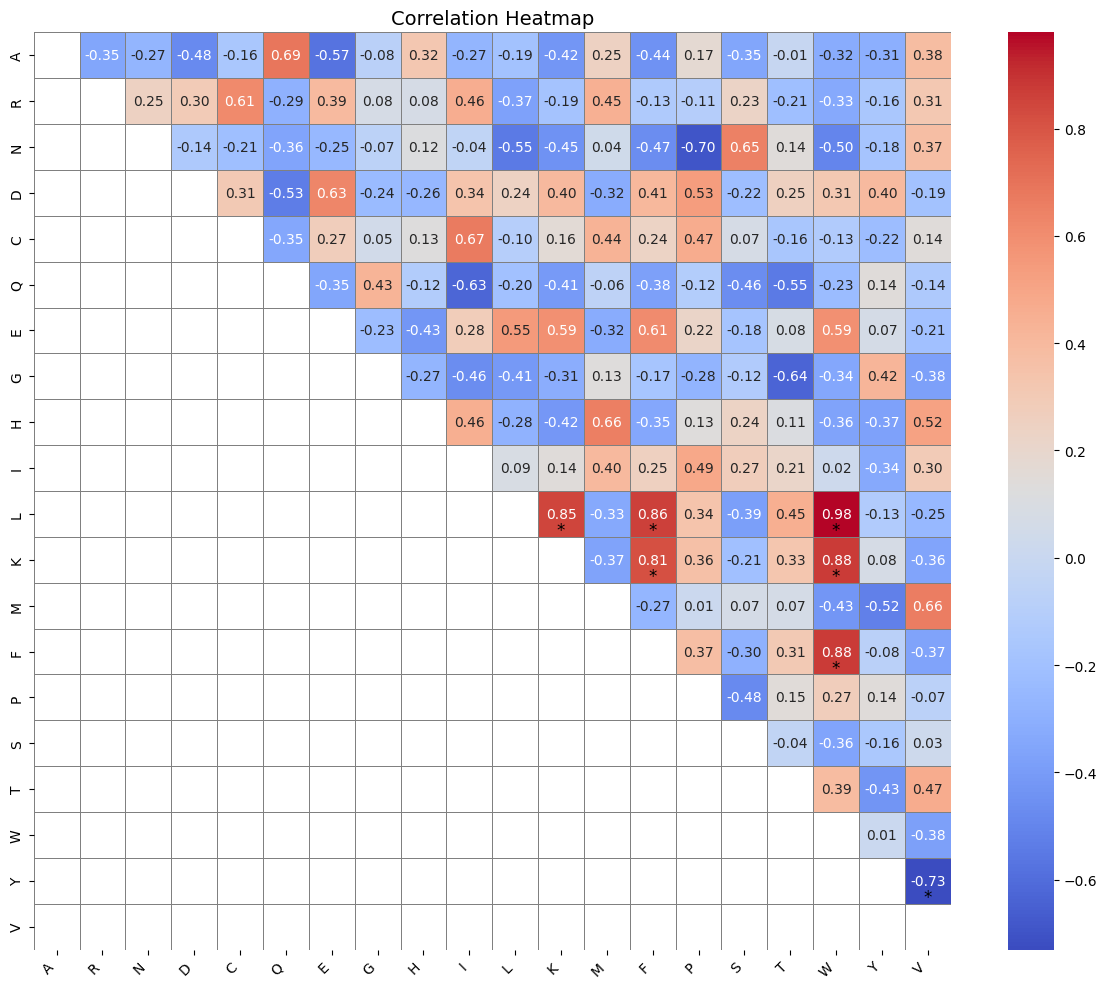

In [ ]:
amino_acids_prions = group_1.iloc[:, 4:24]
column_names = amino_acids_prions.columns
n_cols = len(column_names)
correlations = np.full((n_cols, n_cols), np.nan)
p_values = np.full((n_cols, n_cols), np.nan)

for i in range(len(column_names)):
    for j in range(i+1, len(column_names)):
          corr, p = pearsonr(amino_acids_prions.iloc[:, i], amino_acids_prions.iloc[:, j])
          correlations[i, j] = corr
          p_values[i, j] = p

plt.figure(figsize=(12, 10))
ax = sns.heatmap(correlations,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            cbar=True,
            xticklabels=column_names,
            yticklabels=column_names,
            mask=np.isnan(correlations), # to not color diagnoal entries
            linewidths=0.5,
            linecolor='gray')
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Heatmap", fontsize=14)

for i in range(len(column_names)):
    for j in range(i+1, len(column_names)):
        if i != j and p_values[i, j] < 0.05 and abs(correlations[i, j]) >= 0.7: # i decided this just to focus on the most important correlations
            ax.text(j + 0.5, i + 0.85, '*', color='black', ha='center', va='center', fontsize=12) # to control the position of the "*"


plt.tight_layout()
plt.savefig('Correlation Heatmap Prions.jpg', dpi=500)

# **Preparing mutant libraries for WALTZ analysis.**

# Generating Mutant Sequences

In [ ]:
# for mutating amino acids
def generate_mutated_sequences(df, from_letter, to_letters, save_dir, split_pos):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    mutated_dfs = {}

    for _, row in df.iterrows():
        gene_name = row['Gene Name']
        prd_seq = row['PrD Protein Sequence']

        # find all positions of the source amino acid (to be mutated from)
        positions = [i for i, aa in enumerate(prd_seq) if aa == from_letter]

        if not positions:  # if letter isn't found, skip
            continue

        prd_start, _ = map(int, split_pos[gene_name].split('-'))

        # initialize list with the original sequence (first line in FASTA file)
        mutated_sequences = [{
            "ID": row["ID"],
            "Gene Name": gene_name,
            "PrD Protein Sequence": prd_seq
        }]

        # generate mutations and group them by position (such that SUP35;P41L is followed by SUP35;P41S, and so on..)
        for pos in positions:
            for to_letter in to_letters:
                new_prd_seq = list(prd_seq) # because lists are mutable, not strings
                new_prd_seq[pos] = to_letter
                original_position = pos + prd_start
                mutation_label = f"{from_letter}{original_position}{to_letter}"

                mutated_sequences.append({
                    "ID": row["ID"],
                    "Gene Name": f"{gene_name};{mutation_label}",
                    "PrD Protein Sequence": "".join(new_prd_seq), # convering list back to string
                })

        mutated_df = pd.DataFrame(mutated_sequences)

        fasta_path = os.path.join(save_dir, f"{gene_name}.fasta")
        with open(fasta_path, 'w') as fasta_file:
            for _, row in mutated_df.iterrows():
                fasta_file.write(f">{row['Gene Name']}\n{row['PrD Protein Sequence']}\n")

        mutated_dfs[gene_name] = mutated_df

    return mutated_dfs

In [ ]:
# for mutating nucleotides

codon_table = CodonTable.unambiguous_dna_by_id[1]
stop_codons = {"TAA", "TAG", "TGA"}

def mutate_and_translate_dna(dna_seq, mutate_pos, from_nt, to_nt):

    mutated_dna = list(dna_seq) # because lists are mutable, not strings
    mutated_dna[mutate_pos] = to_nt
    mutated_dna_seq = "".join(mutated_dna) # convering list back to string

    mutated_protein = str(Seq(mutated_dna_seq).translate(to_stop=False, table=codon_table)) # translating the mutated sequence

    for i, aa in enumerate(mutated_protein):
        if aa == "*":  # if a stop codon is found
            mutated_protein = mutated_protein[:i]  # truncate just before the stop codon..
            break

    return mutated_protein

def generate_mutated_sequences(df, from_nuc, to_nuc, save_dir, split_pos):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    mutated_dfs = {}

    for _, row in df.iterrows():
        gene_name = row['Gene Name']
        prd_dna_seq = row['Sequence']
        prd_prot_seq = row['Protein Sequence']

        # find all positions of the source amino acid (to be mutated from)
        positions = [i for i, nt in enumerate(prd_dna_seq) if nt == from_nuc]

        if not positions:  # if letter isn't found, skip
            continue

        prd_start, _ = map(int, split_pos[gene_name].split('-'))

        # Initialize list with the original sequence (first line in FASTA file)
        mutated_sequences = [{
            "ID": row["ID"],
            "Gene Name": gene_name,
            "Protein Sequence": prd_prot_seq
        }]

        for pos in positions: # for every position the nt to be mutated is found
            mutated_protein = mutate_and_translate_dna(prd_dna_seq, pos, from_nuc, to_nuc) # applying the mutate_and_translate function coded above to mutate the DNA sequence at that particular position

            # Identify affected amino acid
            aa_index = pos // 3  # Convert nucleotide index to amino acid index. If a nucleotide is at index 7 (pos 8), that means its floor division is index 2 (aa of pos 3).
            if aa_index >= len(prd_prot_seq):  # Safety check just in case truncations and stop codons mess with anything
                continue

            original_aa = prd_prot_seq[aa_index] # fetch the original amino acid in the protein
            mutated_aa = mutated_protein[aa_index] if aa_index < len(mutated_protein) else "*" # the mutated amino acid is at the same position as that found in the original protein (codon index), but using the mutated_protein string instead of prd_protein_seq
            # if the aa_index for some reason is larger than the length of the mutated protein, it means a truncation happened. In that case, the mutated amino acid is just "*"

            if original_aa == mutated_aa: # in case it's a synonmous mutation, don't add it to the FASTA file or the mutated_dfs dictionary.
                continue

            aa_position = aa_index + prd_start  # Adjust based on PrD start so that the position is relative to the full-length protein
            mutation_label = f"{gene_name};{original_aa}{aa_position}{mutated_aa}" # record the mutated sequence name for FASTA file and WALTZ later

            mutated_sequences.append({
                "ID": row["ID"],
                "Gene Name": mutation_label,
                "Protein Sequence": mutated_protein,
            })

        mutated_df = pd.DataFrame(mutated_sequences)

        fasta_path = os.path.join(save_dir, f"{gene_name}.fasta")
        with open(fasta_path, 'w') as fasta_file:
            for _, row in mutated_df.iterrows():
              if len(row['Protein Sequence']) < 6:
                continue # don't add short sequences to FASTA file
              fasta_file.write(f">{row['Gene Name']}\n{row['Protein Sequence']}\n")

        mutated_dfs[gene_name] = mutated_df

    return mutated_dfs

In [ ]:
save_dir = '/content/drive/MyDrive/Lin Chen Rotation/Mutations/WALTZ - Cytosine to Uracil'
mutated_dfs = generate_mutated_sequences(prd_sequences, "C", "T", save_dir, split_positions)

In [ ]:
mutated_dfs['SUP35']

,ID,Gene Name,Protein Sequence
0,YDR172W,SUP35,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...
1,YDR172W,SUP35;S2L,MLDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...
2,YDR172W,SUP35;S4L,MSDLNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...
3,YDR172W,SUP35;Q6*,MSDSN
4,YDR172W,SUP35;Q10*,MSDSNQGNN
...,...,...,...
59,YDR172W,SUP35;S125F,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...
60,YDR172W,SUP35;Q130*,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...
61,YDR172W,SUP35;Q132*,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...
62,YDR172W,SUP35;Q133*,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...


# Analyzing WALTZ Results (C->U Mutations)

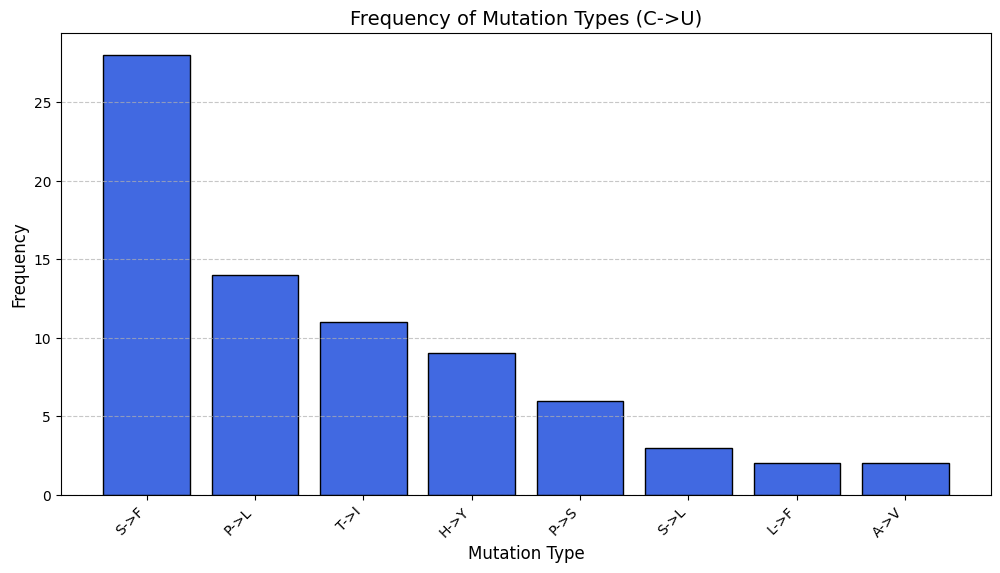

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re

# Raw mutation data (written by me in this format)
mutation_data = """
CYC8 (206 mutations)
P476L, H537Y, P613L, P613S, H624Y, P628L

GLN3 (33 mutations)
P184S, P184L, S190F, P197S, P197L, T205I, H211Y, T231I

MOD5 (8 mutations)
T201I

MOT3 (165 mutations)
H36Y, T45I, P57L, S74F, P115L, S130F, S132F, H159Y, T260I

NEW1 (66 mutations)
S11F, S25F

PIN2 (23 mutations)
P224L, L246F, S269L

PUB1 (54 mutations)
S315F, T342I, A343V, P349S, P349L, P359S, P359L, H372Y

RNQ1 (121 mutations)
S173F, S183F, S187F, S209F, S213F, S223F, S233F, S276F, S334F, S340F, S380F, S386F, S390F

SFP1 (115 mutations)
S257F, A258V, T291I, S308F, S329L, S331F, H334Y, S361F, H380Y, S451F

SKY1 (42 mutations)
S397L

SUP35 (62 mutations)
P75L

SWI1 (139 mutations)
T27I, T32I, T58I, S108F, P141L, T154I, P161L, S212F, P238S, P238L, H288Y

URE2 (25 mutations)
L12F, S13F
"""

# extract all mutations using regex
mutation_list = re.findall(r'([A-Z])\d+([A-Z])', mutation_data)

# count occurrences of each mutation type (e.g., S->F, T->I) using the Counter package to count hashable items
mutation_counts = Counter(f"{orig}->{mut}" for orig, mut in mutation_list)

# sort by count in descending order
sorted_mutations = sorted(mutation_counts.items(), key=lambda x: x[1], reverse=True)
mutation_types, frequencies = zip(*sorted_mutations) # separate the mutation types from the numbers

plt.figure(figsize=(12, 6))
plt.bar(mutation_types, frequencies, color="royalblue", edgecolor="black")
plt.xlabel("Mutation Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.title("Frequency of Mutation Types (C->U)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()
plt.savefig('Frequency of Mutation Types.jpg', dpi=500)

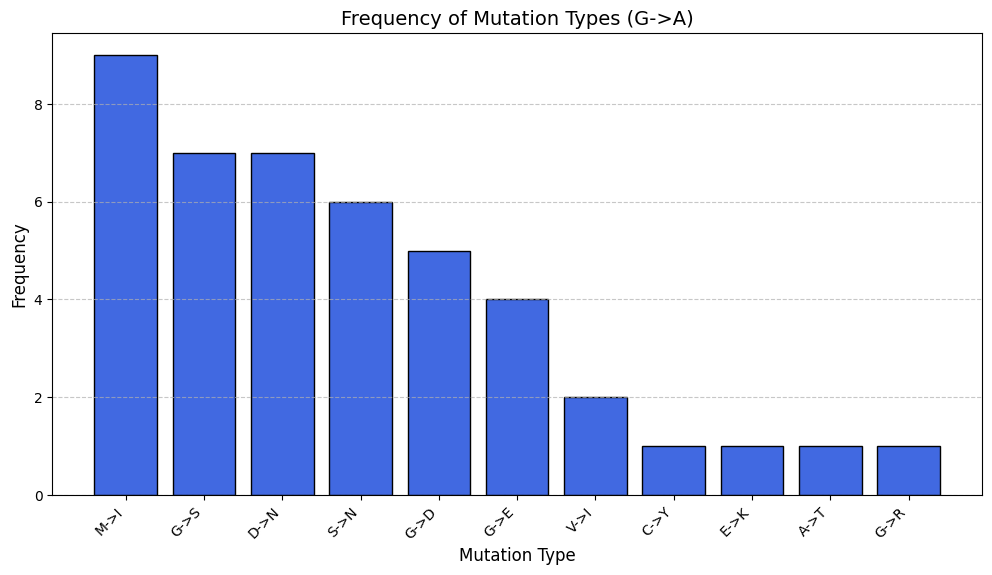

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re


mutation_data = """
CYC8 (71 mutations)
V679I --> 1 hit

GLN3 (13 mutations)
M228I --> 1 hit

MOD5 (5 mutations)
0 hits

MOT3 (80 mutations)
G49S, S97N, M111I, D133N, M169I, M196I --> 6 hits

NEW1 (48 mutations)
G96D, G98S --> 2 hits

PIN2 (18 mutations)
D227N, D230N, S250N --> 3 hits

PUB1 (42 mutations)
D396N, C379Y --> 2 hits

RNQ1 (115 mutations)
M185I, G229S, G305D, E385K --> 4 hits

SFP1 (73 mutations)
M266I, M304I, S418N, G419D, M434I --> 5 hits

SKY1 (53 mutations)
M403I, S432N, D489N --> 3 hits

SUP35 (56 mutations)
S17N, G20S, A37T, G43D, G44E, G54R, G54E, G58S, G59S, G112E --> 10 hits

SWI1 (86 mutations)
D2N, D172N, V201I, S214N --> 4 hits

URE2 (33 mutations)
G22E, G42S, G42D --> 3 hits
"""


mutation_list = re.findall(r'([A-Z])\d+([A-Z])', mutation_data)

mutation_counts = Counter(f"{orig}->{mut}" for orig, mut in mutation_list)

sorted_mutations = sorted(mutation_counts.items(), key=lambda x: x[1], reverse=True)
mutation_types, frequencies = zip(*sorted_mutations)

plt.figure(figsize=(12, 6))
plt.bar(mutation_types, frequencies, color="royalblue", edgecolor="black")
plt.xlabel("Mutation Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.title("Frequency of Mutation Types (G->A)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()
plt.savefig('Frequency of Mutation Types.jpg', dpi=500)

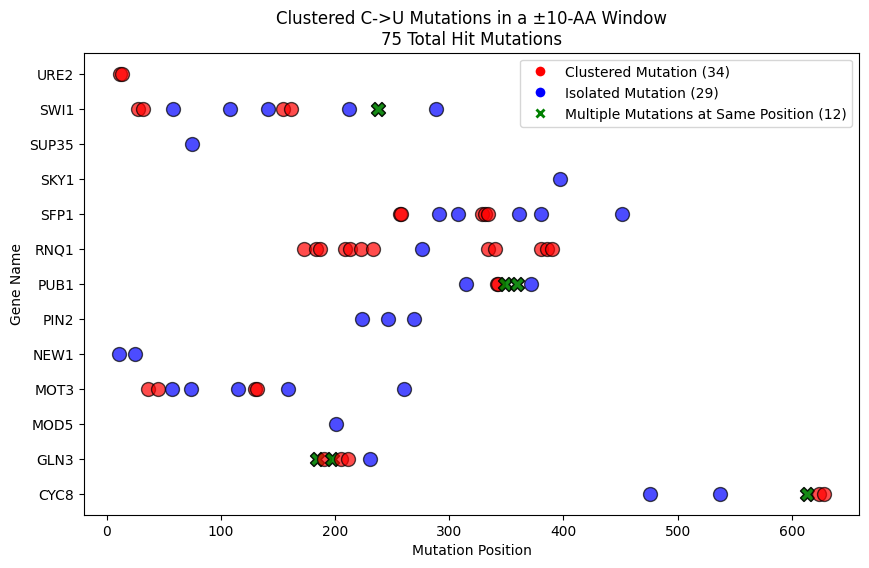

In [28]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from matplotlib.lines import Line2D

mutation_data = """
CYC8 (206 mutations)
P476L, H537Y, P613L, P613S, H624Y, P628L --> 6 hits

GLN3 (33 mutations)
P184S, P184L, S190F, P197S, P197L, T205I, H211Y, T231I --> 8 hits

MOD5 (8 mutations)
T201I --> 1 hit

MOT3 (165 mutations)
H36Y, T45I, P57L, S74F, P115L, S130F, S132F, H159Y, T260I --> 9 hits

NEW1 (66 mutations)
S11F, S25F --> 2 hits

PIN2 (23 mutations)
P224L, L246F, S269L --> 3 hits

PUB1 (54 mutations)
S315F, T342I, A343V, P349S, P349L, P359S, P359L, H372Y --> 8 hits

RNQ1 (121 mutations)
S173F, S183F, S187F, S209F, S213F, S223F, S233F, S276F, S334F, S340F, S380F, S386F, S390F --> 13 hits

SFP1 (115 mutations)
S257F, A258V, T291I, S308F, S329L, S331F, H334Y, S361F, H380Y, S451F --> 10 hits

SKY1 (42 mutations)
S397L --> 1 hit

SUP35 (62 mutations)
P75L --> 1 hit

SWI1 (139 mutations)
T27I, T32I, T58I, S108F, P141L, T154I, P161L, S212F, P238S, P238L, H288Y --> 11 hits

URE2 (25 mutations)
L12F, S13F --> 2 hits

"""

# parse mutations and positions
mutations_by_gene = defaultdict(list) # makes a dictionary where the key is going to be the gene name and the value is a list of mutation positions (not types)
gene_name = None # initializing variable to store gene names
position_mutation_counts = defaultdict(lambda: defaultdict(int))

# parsing mutation data
for line in mutation_data.split("\n"):
    line = line.strip() # looping over every line in the structure I wrote

    if not line: # if the line is empty (white space or something)
        continue

    # get the gene name if the line contains a gene name ("CYC8 (206 mutations)") and so on... in the regex format below
    match = re.match(r"(\w+)\s+\(\d+\s+mutations\)", line) # regex to get gene name based on the data structure I've written
    if match:
        gene_name = match.group(1) # if the line does contain a gene name, put it in the gene_name variable which was declared above
        continue

    # if the line contains mutations
    if "-->" in line:
        mutations = line.split("-->")[0].strip().split(", ") # for example, S11F, S25F --> 2 hits will get S11F and S25F
        for mut in mutations: # for each one of those mutations
            match = re.match(r"([A-Z])(\d+)([A-Z])", mut)  # extract the position based on a regex
            if match:
              orig, pos, new = match.groups()
              pos = int(pos)  # get the position (11, 25, etc.)
              mutations_by_gene[gene_name].append(pos) # append these positions to the gene_name found earlier
              position_mutation_counts[gene_name][pos] += 1 # count mutations at each position (either will be 1 or 2 since I haven't found any positions to have 3 different mutational possibilities to increase WALTZ score)

# count co-occurring mutations (within a window of 10-amino acids) and prepare for visualization
total_mutations = 0
isolated_mutations = 0
clustered_mutations = 0
multiple_mutations = 0

all_positions = []
all_colors = []
all_markers = []
all_gene_labels = []

for gene, positions in mutations_by_gene.items():
    if not positions:
        continue

    positions.sort()
    clustered_positions = set()

    for i, pos in enumerate(positions):
        is_clustered = any(abs(pos - other_pos) <= 10 for other_pos in positions if pos != other_pos)

        marker = "o"
        color = "blue"

        if position_mutation_counts[gene][pos] > 1:
            marker = "X"
            color = "green"
            multiple_mutations += 1
        elif is_clustered:
            marker = "o"
            color = "red"
            clustered_mutations += 1
            clustered_positions.add(pos)
        else:
            isolated_mutations += 1

        all_positions.append(pos)
        all_gene_labels.append(gene)
        all_markers.append(marker)
        all_colors.append(color)

    total_mutations += len(positions)

plt.figure(figsize=(10, 6))

for pos, gene, color, marker in zip(all_positions, all_gene_labels, all_colors, all_markers):
    plt.scatter(pos, gene, c=color, alpha=0.7, edgecolors="black", marker=marker, s=100)

plt.xlabel("Mutation Position")
plt.ylabel("Gene Name")
plt.title(f"Clustered C->U Mutations in a ±10-AA Window\n{total_mutations} Total Hit Mutations")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Clustered Mutation ({clustered_mutations})', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'Isolated Mutation ({isolated_mutations})', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='X', color='w', label=f'Multiple Mutations at Same Position ({multiple_mutations})', markerfacecolor='green', markersize=8)
]
plt.legend(handles=legend_elements)

# plt.show()
plt.savefig('Clustered C->U Mutations.jpg', dpi=500)

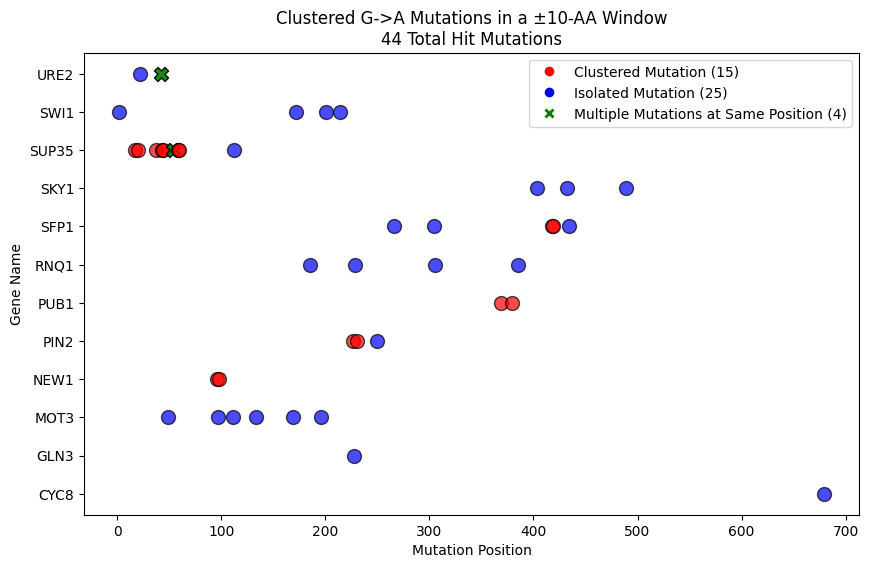

In [29]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from matplotlib.lines import Line2D

mutation_data = """
CYC8 (71 mutations)
V679I --> 1 hit

GLN3 (13 mutations)
M228I --> 1 hit

MOD5 (5 mutations)
0 hits

MOT3 (80 mutations)
G49S, S97N, M111I, D133N, M169I, M196I --> 6 hits

NEW1 (48 mutations)
G96D, G98S --> 2 hits

PIN2 (18 mutations)
D227N, D230N, S250N --> 3 hits

PUB1 (42 mutations)
D369N, C379Y --> 2 hits

RNQ1 (115 mutations)
M185I, G229S, G305D, E385K --> 4 hits

SFP1 (73 mutations)
M266I, M304I, S418N, G419D, M434I --> 5 hits

SKY1 (53 mutations)
M403I, S432N, D489N --> 3 hits

SUP35 (56 mutations)
S17N, G20S, A37T, G43D, G44E, G54R, G54E, G58S, G59S, G112E --> 10 hits

SWI1 (86 mutations)
D2N, D172N, V201I, S214N --> 4 hits

URE2 (33 mutations)
G22E, G42S, G42D --> 3 hits

"""

# parse mutations and positions
mutations_by_gene = defaultdict(list) # makes a dictionary where the key is going to be the gene name and the value is a list of mutation positions (not types)
gene_name = None # initializing variable to store gene names
position_mutation_counts = defaultdict(lambda: defaultdict(int))

# parsing mutation data
for line in mutation_data.split("\n"):
    line = line.strip() # looping over every line in the structure I wrote

    if not line: # if the line is empty (white space or something)
        continue

    # get the gene name if the line contains a gene name ("CYC8 (206 mutations)") and so on... in the regex format below
    match = re.match(r"(\w+)\s+\(\d+\s+mutations\)", line) # regex to get gene name based on the data structure I've written
    if match:
        gene_name = match.group(1) # if the line does contain a gene name, put it in the gene_name variable which was declared above
        continue

    # if the line contains mutations
    if "-->" in line:
        mutations = line.split("-->")[0].strip().split(", ") # for example, S11F, S25F --> 2 hits will get S11F and S25F
        for mut in mutations: # for each one of those mutations
            match = re.match(r"([A-Z])(\d+)([A-Z])", mut)  # extract the position based on a regex
            if match:
              orig, pos, new = match.groups()
              pos = int(pos)  # get the position (11, 25, etc.)
              mutations_by_gene[gene_name].append(pos) # append these positions to the gene_name found earlier
              position_mutation_counts[gene_name][pos] += 1 # count mutations at each position (either will be 1 or 2 since I haven't found any positions to have 3 different mutational possibilities to increase WALTZ score)

# count co-occurring mutations (within a window of 10-amino acids) and prepare for visualization
total_mutations = 0
isolated_mutations = 0
clustered_mutations = 0
multiple_mutations = 0

all_positions = []
all_colors = []
all_markers = []
all_gene_labels = []

for gene, positions in mutations_by_gene.items():
    if not positions:
        continue

    positions.sort()
    clustered_positions = set()

    for i, pos in enumerate(positions):
        is_clustered = any(abs(pos - other_pos) <= 10 for other_pos in positions if pos != other_pos)

        marker = "o"
        color = "blue"

        if position_mutation_counts[gene][pos] > 1:
            marker = "X"
            color = "green"
            multiple_mutations += 1
        elif is_clustered:
            marker = "o"
            color = "red"
            clustered_mutations += 1
            clustered_positions.add(pos)
        else:
            isolated_mutations += 1

        all_positions.append(pos)
        all_gene_labels.append(gene)
        all_markers.append(marker)
        all_colors.append(color)

    total_mutations += len(positions)

plt.figure(figsize=(10, 6))

for pos, gene, color, marker in zip(all_positions, all_gene_labels, all_colors, all_markers):
    plt.scatter(pos, gene, c=color, alpha=0.7, edgecolors="black", marker=marker, s=100)

plt.xlabel("Mutation Position")
plt.ylabel("Gene Name")
plt.title(f"Clustered G->A Mutations in a ±10-AA Window\n{total_mutations} Total Hit Mutations")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Clustered Mutation ({clustered_mutations})', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'Isolated Mutation ({isolated_mutations})', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='X', color='w', label=f'Multiple Mutations at Same Position ({multiple_mutations})', markerfacecolor='green', markersize=8)
]
plt.legend(handles=legend_elements)

# plt.show()
plt.savefig('Clustered G->A Mutations.jpg', dpi=500)